In [1]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.5/677.5 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 8.3 MB/s eta 0:00:00


In [2]:
import mlflow
import mlflow.sklearn
import time
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

import shutil
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import re
import spacy
import gensim
from gensim.parsing.preprocessing import STOPWORDS
from bs4 import BeautifulSoup
from scipy import sparse

import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import joblib

from gensim.models.ldamodel import LdaModel
from gensim.utils import simple_preprocess
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from transformers import AutoTokenizer, AutoModel
import torch
import os

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
os.makedirs("/kaggle/working/models", exist_ok=True)

In [4]:
mlflow.set_tracking_uri("/kaggle/working/mlruns")

mlflow.set_experiment("Classic_Supervised")

print("MLflow configuré sur Kaggle ! Logs enregistrés dans /kaggle/working/mlruns")

2025/03/12 23:17:38 INFO mlflow.tracking.fluent: Experiment with name 'Classic_Supervised' does not exist. Creating a new experiment.


MLflow configuré sur Kaggle ! Logs enregistrés dans /kaggle/working/mlruns


In [5]:
data = pd.read_csv('/kaggle/input/bigot-benjamin-1-notebook-exploration-022025/preprocessed_data.csv')
np.random.seed(42)

In [6]:
# Séparer le dataset en Train (80%) et Test (20%)
X = data.drop(columns=["Tags"])
Y = data["Tags"]
X_train, X_test, y_train_raw, y_test_raw = train_test_split(X, Y, test_size=0.2, random_state=42)

# Vérifier la taille des jeux de données
print(f"Taille du train : {len(X_train)}")
print(f"Taille du test : {len(X_test)}")

Taille du train : 40000
Taille du test : 10000


In [7]:
# Bag-of-Words
vectorizer_count = CountVectorizer(max_features=5000, stop_words="english")
X_train_count = vectorizer_count.fit_transform(X_train['Processed'])
X_test_count = vectorizer_count.transform(X_test['Processed'])

# TF-IDF
vectorizer_tfidf = TfidfVectorizer(max_features=5000, stop_words="english")
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train['Processed'])
X_test_tfidf = vectorizer_tfidf.transform(X_test['Processed'])

In [8]:
y_train_raw = y_train_raw.apply(lambda x: x.strip("<>").split("><"))
y_test_raw = y_test_raw.apply(lambda x: x.strip("<>").split("><"))

In [9]:
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train_raw)
y_test = mlb.transform(y_test_raw)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['100mslive', '3d-convolution', '3ds', '4g', '8thwall-web', 'aapt', 'aasa', 'abseil', 'abstract-methods', 'acceptance-testing', 'access-point', 'acid', 'acr1252', 'action-button', 'action-mapping', 'actionscript-3', 'activesupport-concern', 'activitylog', 'add-custom-target', 'add-filter', 'addrange', 'adjacency-matrix', 'adonisjs-ace', 'advanced-threat-protection', 'aero', 'aframe', 'ag-charts-react', 'ag-grid-validation', 'aggregate-filter', 'aio', 'aiven', 'ajaxform', 'alchemy', 'amazon-dynamodb-dax', 'amazon-gamelift', 'amazon-polly', 'ambiguity', 'ampersand', 'ampscript', 'ancestor', 'android-12l', 'android-7.0-nougat', 'android-arrayadapter', 'android-broadcast', 'android-companion-device', 'android-compose-image', 'android-contentprovider', 'android-context', 'android-darkmode', 'android-dynamic-shortcuts', 'android-firmware', 'android-homebutton', 'android-junit', 'androi

In [10]:
tag_frequencies = np.sum(y_train, axis=0)
sorted_tags = sorted(zip(tag_frequencies, mlb.classes_), key=lambda x: x[0], reverse=True)
print(sorted_tags[:10])

[(6170, 'python'), (4781, 'javascript'), (3606, 'reactjs'), (3277, 'java'), (2353, 'android'), (2184, 'node.js'), (2006, 'spring-boot'), (2006, 'typescript'), (1634, 'c#'), (1603, 'azure')]


In [11]:
top_counts, top_tags = zip(*sorted_tags[:20])

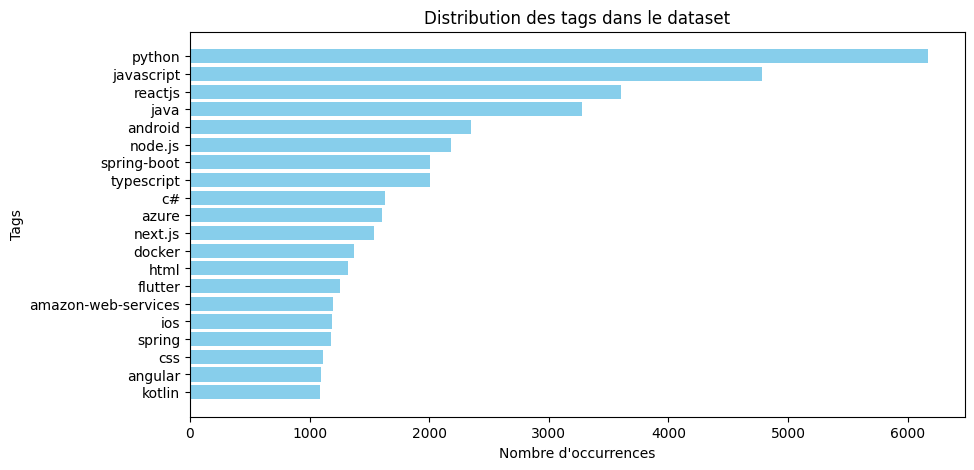

In [12]:
# Tracer la distribution des tags
plt.figure(figsize=(10,5))
plt.barh(top_tags, top_counts, color="skyblue")
plt.xlabel("Nombre d'occurrences")
plt.ylabel("Tags")
plt.title("Distribution des tags dans le dataset")
plt.gca().invert_yaxis()
plt.show()

In [13]:
# Trier les fréquences des tags
sorted_frequencies = np.sort(tag_frequencies)[::-1]

# Calculer la couverture cumulative des tags
cumulative_coverage = np.cumsum(sorted_frequencies) / np.sum(sorted_frequencies)

N_optimal = np.argmax(cumulative_coverage >= 0.80) + 1
print(f"Nombre optimal de tags pour couvrir 80% des données : {N_optimal}")

Nombre optimal de tags pour couvrir 80% des données : 2147


In [14]:
# Sélection des N tags les plus fréquents
N = 2147

selected_tags = np.argsort(-tag_frequencies)[:N]

y_train = y_train[:, selected_tags]
y_test = y_test[:, selected_tags]

# Mettre à jour les noms des tags conservés
mlb.classes_ = mlb.classes_[selected_tags]

In [15]:
print(y_train.shape)
print(y_test.shape)

(40000, 2147)
(10000, 2147)


In [16]:
# Modèle avec Logistic Regression
model = OneVsRestClassifier(LogisticRegression(max_iter=500))
model.fit(X_train_count, y_train)

# Prédictions
y_pred_count = model.predict(X_test_count)
accuracy = jaccard_score(y_test, y_pred_count, average="samples")

with mlflow.start_run():
    mlflow.log_param("model", "OneVsRest + LogisticRegression CountVect")
    mlflow.log_param("max_iter", 500)
    mlflow.log_metric("jaccard_score", accuracy)
    
    # Sauvegarder le modèle
    mlflow.sklearn.log_model(model, "model")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [17]:
model_sgd = OneVsRestClassifier(SGDClassifier(loss="log_loss", max_iter=1000))
model_sgd.fit(X_train_count, y_train)
y_pred_sgd_count = model_sgd.predict(X_test_count)
accuracy_sgd = jaccard_score(y_test, y_pred_sgd_count, average="samples")

with mlflow.start_run():
    mlflow.log_param("model", "OneVsRest + SGDClassifier CountVect")
    mlflow.log_param("max_iter", 500)
    mlflow.log_metric("jaccard_score", accuracy_sgd)
    
    # Sauvegarder le modèle
    mlflow.sklearn.log_model(model_sgd, "model_SGD")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2025/03/13 00:15:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [18]:
# Modèle avec Logistic Regression
model = OneVsRestClassifier(LogisticRegression(max_iter=500))
model.fit(X_train_tfidf, y_train)

# Prédictions
y_pred_tfidf = model.predict(X_test_tfidf)
accuracy = jaccard_score(y_test, y_pred_tfidf, average="samples")

with mlflow.start_run():
    mlflow.log_param("model", "OneVsRest + LogisticRegression TFIDF")
    mlflow.log_param("max_iter", 500)
    mlflow.log_metric("jaccard_score", accuracy)
    
    # Sauvegarder le modèle
    mlflow.sklearn.log_model(model, "model")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2025/03/13 00:24:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [19]:
# Modèle avec Logistic Regression
model = OneVsRestClassifier(SGDClassifier(loss="log_loss", max_iter=1000))
model.fit(X_train_tfidf, y_train)

# Prédictions
y_pred_sgd_tfidf = model.predict(X_test_tfidf)
accuracy = jaccard_score(y_test, y_pred_sgd_tfidf, average="samples")

with mlflow.start_run():
    mlflow.log_param("model", "OneVsRest + SGDClassifier TFIDF")
    mlflow.log_param("max_iter", 500)
    mlflow.log_metric("jaccard_score", accuracy)
    
    # Sauvegarder le modèle
    mlflow.sklearn.log_model(model, "model")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2025/03/13 00:29:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [20]:
score_logreg_count = jaccard_score(y_test, y_pred_count, average="samples")
score_sgd_count = jaccard_score(y_test, y_pred_sgd_count, average="samples")
score_logreg_tfidf = jaccard_score(y_test, y_pred_tfidf, average="samples")
score_sgd_tfidf = jaccard_score(y_test, y_pred_sgd_tfidf, average="samples")

print(f"Jaccard Score - Logistic Regression CV : {score_logreg_count:.4f}")
print(f"Jaccard Score - SGD Classifier CV: {score_sgd_count:.4f}")
print(f"Jaccard Score - Logistic Regression TFIDF: {score_logreg_tfidf:.4f}")
print(f"Jaccard Score - SGD Classifier TFIDF: {score_sgd_tfidf:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Jaccard Score - Logistic Regression CV : 0.2341
Jaccard Score - SGD Classifier CV: 0.2410
Jaccard Score - Logistic Regression TFIDF: 0.1760
Jaccard Score - SGD Classifier TFIDF: 0.0966


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# Probabilités des classes
y_proba = model_sgd.predict_proba(X_test_count)

# Définir un seuil de probabilité
threshold = 0.3

# Fonction pour récupérer les tags qui dépassent le seuil
def get_tags_with_threshold(probas, threshold=0.3):
    indices = np.where(probas >= threshold)[0]
    if len(indices) == 0:
        indices = [np.argmax(probas)]
    return [mlb.classes_[i] for i in indices]

# Appliquer sur toutes les prédictions
predicted_tags = [get_tags_with_threshold(proba, threshold) for proba in y_proba]

# Ajouter les prédictions aux données test
# Créer une copie de X_test pour ajouter les prédictions
X_test_with_predictions = X_test.copy()
X_test_with_predictions["Predicted_Tags"] = predicted_tags

In [22]:
display(X_test_with_predictions.head(10))

,Id,Title,Body,Score,ViewCount,AnswerCount,CreationDate,Processed,Predicted_Tags
33553,76601348,How do I pass in parameters into arrow functio...,"<p><a href=""https://i.sstatic.net/u7abJ.png"" r...",-2,488,2,2023-07-03 01:16:37,"['pass', 'parameter', 'arrow', 'function', 're...","[reactjs, machine-learning, react-hooks, param..."
9427,75749445,How to test @NotBlank spring validation with J...,<p>I am trying to test validation I have a con...,0,1582,2,2023-03-15 19:51:22,"['test', 'spring', 'validation', 'junit', 'try...",[java]
199,75900198,"DBeaver - unable to update driver: ""Network un...",<p>Always getting this error when I try to upd...,5,21968,1,2023-03-31 15:22:24,"['update', 'driver', 'network', 'certificate',...",[sql-server]
12447,76021053,Youtube player API to get server url few times...,<p>I am using this code in PHP to get the Yout...,0,1251,1,2023-04-15 08:08:22,"['player', 'api', 'server', 'url', 'time', 're...","[php, curl]"
39489,78823804,Where is it specified the path to look for ker...,<p>I am launching an Anconda prompt from a Win...,0,398,1,2024-08-02 04:42:33,"['specify', 'path', 'look', 'launch', 'window'...","[python, svg, operating-system]"
42724,75798407,Unable to make Request to FastAPI server using...,<p>I have Created a fastapi python server whic...,-1,356,1,2023-03-21 07:38:58,"['request', 'javascript', 'create', 'server', ...","[python, javascript, html, flask]"
10822,78421291,error[E0658]: use of unstable library feature ...,<p>It seems I can fix this by adding one by on...,0,1406,1,2024-05-02 19:12:30,"['error', 'use', 'library', 'feature', 'restri...","[c++, windows, rust]"
49498,77162580,PrestaShop Server Error (DEV SITE): This site ...,<p>I'm currently facing an issue that has been...,0,280,1,2023-09-23 10:20:42,"['server', 'error', 'dev', 'site', 'site', 're...","[reactjs, wordpress, macos]"
4144,77605224,cannot pickle '_thread.RLock' object while ser...,<p>I am trying to create a langchain model. I ...,2,2937,3,2023-12-05 09:50:54,"['pickle', 'thread', 'object', 'serialize', 'f...","[python, openai-api, langchain, large-language..."
36958,78079896,Upgrading to open api 3 rendering more than re...,<p>I am using open api with spring boot applic...,2,434,1,2024-02-29 08:32:38,"['upgrade', 'api', 'render', 'require', 'entit...","[java, spring-boot]"


In [23]:
X_test_with_predictions.to_csv("X_test_with_predictions_Classic.csv", index=False)

In [24]:
# Compresser tout le répertoire mlruns
shutil.make_archive("/kaggle/working/mlruns_classic", "zip", "/kaggle/working/mlruns")

'/kaggle/working/mlruns_classic.zip'